# Auto Strategy Logger
This notebook lets you input one or more stock symbols, runs the RSI + MA crossover strategy, and logs trade signals and summary to Google Sheets automatically.

In [4]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "modules")))

In [5]:
import pandas as pd
from modules.data_fetcher import DataFetcherFactory
from modules.strategy import TradingStrategy
from modules.google_sheets_writer import GoogleSheetsLogger
from modules.telegram_notifier import TelegramNotifier


# Algo Component – Auto-Triggered Strategy Execution

This component automates the end-to-end trading pipeline:

1. Fetches daily stock data using the Alpha Vantage API.
2. Applies a rule-based trading strategy:
   - Buy signal is generated when RSI < 30
   - Confirmed by 20-day MA crossing above 50-day MA
3. Performs backtesting over a fixed holding period (e.g., 5 days) to simulate trades.
4. Logs trade signals, profit/loss, and summary stats into separate tabs in a Google Sheet.
5. Supports multiple stocks by looping through a user-defined list.

This function can be scheduled or triggered regularly to scan markets,
making it a foundation for automated trading systems.

**User need to enter their Stock Symbol and the Holding period**

In [6]:
# 📥 User Input Section
symbols_input = input("Enter stock symbols (comma separated, e.g., RELIANCE.BSE,TCS.BSE,etc..): ")
symbols = [sym.strip() for sym in symbols_input.split(",")]
holding_period = input("Enter holding period in days (default 5): ")
holding_period = int(holding_period) if holding_period.strip().isdigit() else 5

In [7]:
for symbol in symbols:
    print(f"\nProcessing {symbol}...")
    fetcher = DataFetcherFactory.get_data_fetcher("alpha_vantage")
    df = fetcher.get_daily_data(symbol, outputsize="full")

    if df.empty:
        print(f"No data for {symbol}.")
        continue

    strategy = TradingStrategy(df)
    results = strategy.backtest_signals(holding_period=holding_period)

    if results.empty:
        print(f"No trade signals for {symbol}.")
        continue

    print(f"Logging results to Google Sheets...")

    try:
        sheet_logger = GoogleSheetsLogger(sheet_name= "Stock Signals")
        sheet_logger.write_dataframe(results, "Trade Log")

        summary = pd.DataFrame({
            "Total Trades": [len(results)],
            "Win Ratio": [(results["Result"] == "Win").mean()],
            "Total P&L (₹)": [results["Profit ₹"].sum()]
        })
        sheet_logger.write_dataframe(summary, "Summary")
    except Exception as e:
        print(f"Google Sheets logging failed for {symbol}: {e}")


Processing RELIANCE.BSE...
Logging results to Google Sheets...
Data successfully written to Google Sheets tab: 'Trade Log'
Data successfully written to Google Sheets tab: 'Summary'


# ML Automation
ML Automation (Bonus)
This section implements a basic Logistic Regression model to predict next-day stock movement based on key indicators.

Features:
RSI – Detects oversold/overbought levels

MACD – Measures momentum via EMAs

Volume – Indicates market activity

Target:
1 → Next day’s close > today’s

0 → Otherwise

Model & Evaluation:
Logistic Regression (80/20 train-test split)

Metrics: Accuracy, Classification Report, Confusion Matrix

In [8]:
from modules.ml_model import StockMlModel

In [9]:
model = StockMlModel(df)

In [10]:
model.engineer_features()

Columns before dropna: ['date', 'Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD', 'Target']
Columns after dropna: ['date', 'Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD', 'Target']


In [11]:
model.eda_summary()


Head of data:
         date      Open      High       Low     Close      Volume        RSI  \
14 2005-01-24  353.0118  355.3972  344.1866  345.1748  32549877.0  25.269587   
15 2005-01-25  344.8340  347.7988  339.5182  341.6992  51507608.0  27.993498   
16 2005-01-27  344.1528  349.6046  342.7894  344.9704  39259652.0  33.238826   
17 2005-01-28  344.1528  357.0326  344.1528  356.2492  33198874.0  48.079342   
18 2005-01-31  356.7600  364.4610  356.0788  362.9960  20669563.0  44.764036   

        MACD  Target  
14 -5.848126       0  
15 -6.321690       1  
16 -6.359723       1  
17 -5.417313       1  
18 -4.079015       1  

Summary stats:
                                date         Open         High          Low  \
count                           5030  5030.000000  5030.000000  5030.000000   
mean   2015-04-07 18:47:22.783300096  1330.005970  1346.500016  1312.972370   
min              2005-01-24 00:00:00   344.152800   347.798800   339.518200   
25%              2010-03-05 18:00:

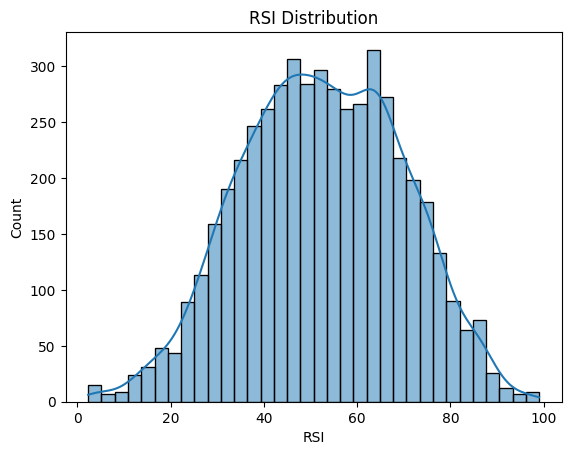

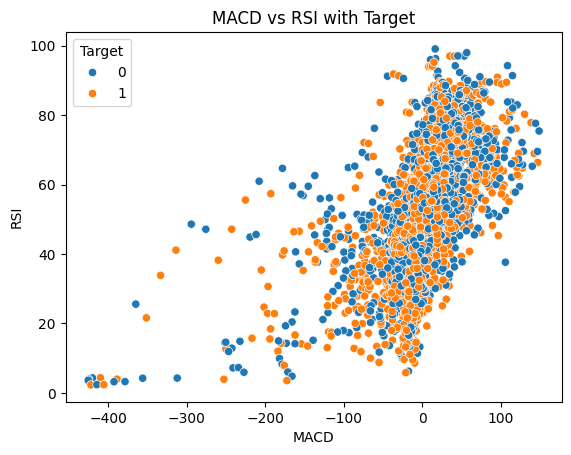

In [12]:
model.visualize_data()

In [13]:
model.train_and_evaluate()


Accuracy: 49.01%

Classification Report:
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       493
           1       0.00      0.00      0.00       513

    accuracy                           0.49      1006
   macro avg       0.25      0.50      0.33      1006
weighted avg       0.24      0.49      0.32      1006


Confusion Matrix:
[[493   0]
 [513   0]]


# Telegram Notification
This section integrates Telegram Bot API to send real-time alerts or error messages from the trading system directly to a Telegram chat.

In [15]:
fetcher = DataFetcherFactory.get_data_fetcher("alpha_vantage")
notifier = TelegramNotifier()

for symbol in symbols:
    print(f"\n🚀 Processing {symbol}...")
    df = fetcher.get_daily_data(symbol, outputsize="full")

    if df.empty:
        error_msg = f"❌ No data for {symbol}."
        print(error_msg)
        notifier.send_alert(error_msg)
        continue

    strategy = TradingStrategy(df)
    trades = strategy.backtest_signals(holding_period=holding_period)

    if trades.empty:
        no_signal_msg = f"⚠️ No trade signals for {symbol}."
        print(no_signal_msg)
        notifier.send_alert(no_signal_msg)
    else:
        print(f"✅ Trades found for {symbol}:")
        print(trades)
        notifier.send_alert(f"✅ Notification sent for {symbol}")


🚀 Processing RELIANCE.BSE...
✅ Trades found for RELIANCE.BSE:
    Buy Date  Buy Price  Sell Date  Sell Price  Profit ₹ Result
0 2017-11-15    804.413 2017-11-22     848.034     43.62    Win
